In [4]:
import requests
from bs4 import BeautifulSoup 

import pandas as pd

import re
import time
import json

from joblib import Parallel, delayed

Взглянем на данные в тестовой выборке, чтобы понять, что надо собрать с auto.ru

In [5]:
test = pd.read_csv('test.csv')
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [7]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

Ограничимся при сборе данных только теми марками автомобилей, которые присутствуют в тестовой выборке:

In [8]:
brands = [brand.lower() for brand in test.brand.unique()]
brands

['skoda',
 'audi',
 'honda',
 'volvo',
 'bmw',
 'nissan',
 'infiniti',
 'mercedes',
 'toyota',
 'lexus',
 'volkswagen',
 'mitsubishi']

Также будем собирать данные о автомобилях с аналогичными годами выпуска. Определим год выпуска самого старого и самого ногово автомобиля в тестовой выборке:

In [9]:
print(test['modelDate'].min(), test['modelDate'].max())

1904 2020


1904 - явная опечатка, посмотрим как выглядит распределение: 

<AxesSubplot:>

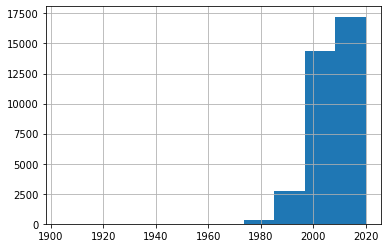

In [10]:
test['modelDate'].hist()

Будем отбирать автомобили 1970 - 2020 годов выпуска

In [11]:
def collect_car_urls(brand: str):
    '''Функция, собирающая url подходящих под условие автомобилей'''

    main_url = f'https://auto.ru/cars/{brand}/used/?year_from=1970&year_to=2020/'   
    main_response = requests.get(main_url)   
    main_soap = BeautifulSoup(main_response.content.decode('utf-8'), 'html.parser')    
    _ = main_soap.find('span', class_='ButtonWithLoader__content').text.replace(u'\xa0', '')
    urls_total = int(re.findall(r'\d+', _)[0])
    ads_per_page = len(main_soap.find_all('a', class_='Link ListingItemTitle__link'))
    pages_num = urls_total // ads_per_page
    
    all_urls = []
    
    for page_num in range(1, pages_num):
        if page_num % 20 == 0:
            print(f"Extracting page {page_num} from {pages_num}...")
        page_url = f'{main_url}?page={page_num}'   
        page_response = requests.get(page_url)
        time.sleep(0.1)
        page_soap = BeautifulSoup(page_response.content.decode('utf-8'), 'html.parser')   
        
        all_urls.extend([a.get('href') for a in page_soap.find_all('a', class_='Link ListingItemTitle__link')])

    return all_urls


In [22]:
urls = []
for brand in brands:
    print(f"Extracting data for the brand {brand}:")
    all_urls = collect_car_urls(brand)
    urls.extend(all_urls)

Extracting data for the brand skoda:
Extracting page 20 from 177...
Extracting page 40 from 177...
Extracting page 60 from 177...
Extracting page 80 from 177...
Extracting page 100 from 177...
Extracting page 120 from 177...
Extracting page 140 from 177...
Extracting page 160 from 177...
Extracting data for the brand audi:
Extracting page 20 from 197...
Extracting page 40 from 197...
Extracting page 60 from 197...
Extracting page 80 from 197...
Extracting page 100 from 197...
Extracting page 120 from 197...
Extracting page 140 from 197...
Extracting page 160 from 197...
Extracting page 180 from 197...
Extracting data for the brand honda:
Extracting page 20 from 123...
Extracting page 40 from 123...
Extracting page 60 from 123...
Extracting page 80 from 123...
Extracting page 100 from 123...
Extracting page 120 from 123...
Extracting data for the brand volvo:
Extracting page 20 from 64...
Extracting page 40 from 64...
Extracting page 60 from 64...
Extracting data for the brand bmw:
Extr

ConnectionError: ('Connection aborted.', ConnectionAbortedError(10053, 'Программа на вашем хост-компьютере разорвала установленное подключение', None, 10053, None))

In [25]:
def get_cars_info(urls, step=0):

    cars_info = pd.DataFrame()
    for url in urls:
        try:
            page = BeautifulSoup(res.content.decode('utf-8'), 'html.parser')
            response = requests.get(url)
            print(f'link={url}, {response.status_code}')
            time.sleep(0.1)
        except:
            pass
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            json_data = None
        try:
            catalog_url = page.find(
                'a', class_='Link SpoilerLink CardCatalogLink SpoilerLink_type_default').get('href')
            response_catalog = requests.get(catalog_url)
            page_catalog = BeautifulSoup(
                response_catalog.content.decode('utf-8'), 'html.parser')
        except:
            print(f'Error get link={url}')
            pass
        try:
            json_data_catalog = json.loads(page_catalog.find(
                'script', type="application/json", id='initial-state').string)
        except:
            pass
        try:
            json_data_equip = json.loads(
                page.find('script', type="application/json", id='initial-state').string)
        except:
            pass
        try:
            json_data['description'] = json_data['description'].replace(
                '\n', ' ')
            json_data['description'] = re.sub(
                '\W+', ' ', json_data['description'])
        except:
            pass
        try:
            options_dict = json_data_catalog['state']['compare']['selected'][0]['options']
            options_list = [key for key in list(
                options_dict.keys()) if options_dict[key] == 1]
        except:
            options_list = []
        try:
            car_url = json_data['offers']['url']
        except:
            car_url = None
        try:
            bodyType = json_data['bodyType']
        except:
            bodyType = None
        try:
            brand = json_data['brand']
        except:
            brand = None
        try:
            color = json_data['color']
        except:
            color = None
        try:
            complectation_dict = options_list
        except:
            complectation_dict = None
        try:
            description = json_data['description']
        except:
            description = None
        try:
            engineDisplacement = json_data['vehicleEngine']['engineDisplacement']
        except:
            engineDisplacement = None
        try:
            enginePower = json_data['vehicleEngine']['enginePower']
        except:
            enginePower = None
        try:
            equipment_dict = json_data_equip['card']['vehicle_info']['equipment']
        except:
            equipment_dict = None
        try:
            fuelType = json_data['fuelType']
        except:
            fuelType = None
        try:
            image = json_data['image']
        except:
            image = None
        try:
            mileage = page.find('li', class_='CardInfoRow CardInfoRow_kmAge').find_all(
                'span')[-1].text.replace(u'\xa0', u' ')
        except:
            mileage = None
        try:
            modelDate = json_data['modelDate']
        except:
            modelDate = None
        try:
            model_name = page.find_all(
                'div', class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren BreadcrumbsPopup')[1].text
        except:
            model_name = None
        try:
            name = json_data['name']
        except:
            name = None
        try:
            numberOfDoors = json_data['numberOfDoors']
        except:
            numberOfDoors = None
        try:
            parsing_unixtime = int(time.time())
        except:
            parsing_unixtime = None
        try:
            price = json_data['offers']['price']
        except:
            price = None
        try:
            priceCurrency = json_data['offers']['priceCurrency']
        except:
            priceCurrency = None
        try:
            productionDate = json_data['productionDate']
        except:
            productionDate = None
        try:
            sell_id = page.find(
                'div', class_='CardHead__infoItem CardHead__id').text[2:]
        except:
            sell_id = None
        try:
            views = page.find(
                'div', class_='CardHead__infoItem CardHead__views').text.split()[0]
        except:
            views = None
        try:
            date_added = page.find(
                'div', class_='CardHead__infoItem CardHead__creationDate').text
        except:
            date_added = None
        try:
            super_gen = json.loads(
                page.find('div', id="sale-data-attributes").get('data-bem'))
        except:
            super_gen = None
        try:
            vehicleConfiguration = json_data['vehicleConfiguration']
        except:
            vehicleConfiguration = None
        try:
            vehicleTransmission = json_data['vehicleTransmission']
        except:
            vehicleTransmission = None
        try:
            Владельцы = page.find('li', class_='CardInfoRow CardInfoRow_ownersCount').find_all(
                'span')[-1].text.replace(u'\xa0', u' ')
        except:
            Владельцы = None
        try:
            Владение = page.find(
                'li', class_='CardInfoRow CardInfoRow_owningTime').find_all('span')[-1].text
        except:
            Владение = None
        try:
            ПТС = page.find('li', class_='CardInfoRow CardInfoRow_pts').find_all(
                'span')[-1].text
        except:
            ПТС = None
        try:
            Привод = page.find('li', class_='CardInfoRow CardInfoRow_drive').find_all(
                'span')[-1].text
        except:
            Привод = None
        try:
            Руль = page.find('li', class_='CardInfoRow CardInfoRow_wheel').find_all(
                'span')[-1].text
        except:
            Руль = None
        try:
            Состояние = page.find(
                'li', class_='CardInfoRow CardInfoRow_state').find_all('span')[-1].text
        except:
            Состояние = None
        try:
            Таможня = page.find(
                'li', class_='CardInfoRow CardInfoRow_customs').find_all('span')[-1].text
        except:
            Таможня = None
        try:
            region = page.find('div', class_='CardBreadcrumbs').find_all(
                'div', class_='CardBreadcrumbs__item')[-1].text.replace(u'\xa0', u' ')
        except:
            region = None
        row = {'car_url': car_url, 'bodyType': bodyType, 'brand': brand, 'color': color,
               'complectation_dict': complectation_dict, 'description': description,
               'engineDisplacement': engineDisplacement, 'enginePower': enginePower,
               'equipment_dict': equipment_dict, 'fuelType': fuelType, 'image': image,
               'mileage': mileage, 'modelDate': modelDate, 'model_name': model_name,
               'name': name, 'numberOfDoors': numberOfDoors, 'parsing_unixtime': parsing_unixtime,
               'price': price, 'priceCurrency': priceCurrency, 'productionDate': productionDate,
               'sell_id': sell_id, 'views': views, 'date_added': date_added,
               'super_gen': super_gen, 'vehicleConfiguration': vehicleConfiguration,
               'vehicleTransmission': vehicleTransmission, 'Владельцы': Владельцы,
               'Владение': Владение, 'ПТС': ПТС, 'Привод': Привод, 'Руль': Руль,
               'Состояние': Состояние, 'Таможня': Таможня, 'region': region}
        cars_info = pd.concat([cars_info, pd.DataFrame([row])])
        step += 1
        if step % 10 == 0:
            print(f'Completed {step} of total {len(urls)}')
        else:
            continue
    return cars_info

In [ ]:
get_cars_info(urls)

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1053796368-f431df25/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105828271-5722ab7b/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Completed 10 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106128687-ad90204e/
E

Completed 100 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105692008-a29d22fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106057475-769aad0c/
Completed 110 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105985

Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106060333-cf3f8095/
Completed 210 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105873403-f7a3c4b6/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105357884-a3787de1/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Completed 220 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Completed 310 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Completed 320 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/11054

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1053796368-f431df25/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Completed 420 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error ge

Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Completed 530 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1053796368-f431df25/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105907016-a2403565/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106075696-c2994737/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103092494-f94e41d7/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105628941-a7874390/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Completed 640 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105973674-02a2c2af/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105793944-2f23f38f/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Completed 740 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105970364-2fd498be/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105952655-84d4dbad/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Er

Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Completed 840 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Completed 850 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105876908-90c94cb5/
Completed 950 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1053796368-f431df25/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105357884-a3787de1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Completed 1050 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105357884-a3787de1/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105793944-2f23f38f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Completed 1160 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Completed 1250 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105952655-84d4dbad/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Completed 1260 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/f

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106048855-e46f4a3c/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106136473-6a210c90/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Completed 1360 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105793944-2f23f38f/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105699888-a39141f1/
E

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Completed 1460 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105357884-a3787de1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105616881-260801af/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/
Completed 1560 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error

Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105490617-1b1f210e/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Completed 1660 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105823304-7451e1f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105793944-2f23f38f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Completed 1760 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106057475-769aad0c/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
E

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105767237-b4222139/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106137012-26afe47b/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106109233-c42f718b/
Completed 1860 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105480901-217d4b13/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105938230-35486b5b/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Completed 1960 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105876908-90c94cb5/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105743785-bed84d48/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105973841-2d7badbc/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105823304-7451e1f8/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105967923-fa8211db/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Completed 1970 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106093914-5af33054/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Completed 2070 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106060333-cf3f8095/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get lin

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Completed 2170 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105555648-85b98fd8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Completed 2270 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105876908-90c94cb5/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Completed 2370 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105816681-20680c2a/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Completed 2470 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105580228-da09b0cf/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error 

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Completed 2570 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105688308-1549c99e/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105842239-b543482f/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105555648-85b98fd8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105069099-d0e2f74e/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105945502-010268df/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106111791-7051692b/
Completed 2580 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octav

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Completed 2680 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1106081287-fc2d0b2c/
Err

Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Completed 2780 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105952655-84d4dbad/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103092494-f94e41d7/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1104959097-5d50fcd7/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106060333-cf3f8095/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105507949-d882d8e2

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Completed 2880 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1106081287-fc2d0b2c/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106125707-1ca26a4f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105520314-1b6ba2fc/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105743785-bed84d48/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Completed 2980 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Completed 3080 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105874139-a5bac9fd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Completed 3090 of total 60648
Error get link=https://auto.ru/cars/used/sale/skod

Completed 3180 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105823304-7451e1f8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106026205-546b168c/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106075696-c2994737/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105642260-f8b61636/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105394565-d99cfa34/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105945502-010268df/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105895460-8b2a2e80/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Completed 3190 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105616881-260801af/
Error get link=https://auto.ru/cars/used/sale/skoda/octavi

Completed 3280 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Completed 3290 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/supe

Completed 3380 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106109154-2bac45cd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1106138936-539f740e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106026205-546b168c/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Completed 3390 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda

Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Completed 3480 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/


Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Completed 3580 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106128687-ad90204e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get li

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Completed 3680 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Completed 3790 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Er

Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105970364-2fd498be/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106139174-393d256e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Completed 3890 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106057475-769aad0c/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106026205-546b168c/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105972823-deb4bbc4/
Completed 3990 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Completed 4090 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105846104-2196e00e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105283224-c64cea3d/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105774251-96d89d42/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105467638-97a4b665/
Error 

Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Completed 4190 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Er

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Completed 4290 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Err

Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105992900-2e403739/
Completed 4390 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106133764-e0bcefa5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105882173-fda97d02/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106087097-33d43b4a/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106075696-c2994737/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Completed 4490 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106128687-ad90204e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106139174-393d256e/
Completed 4590 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Completed 4690 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105999040-5cdf4dd9/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error 

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106075696-c2994737/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Completed 4790 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get 

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105828271-5722ab7b/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105689306-09290333/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Completed 4890 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Completed 4990 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106111791-7051692b/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105743785-bed84d48/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105952655-84d4dbad/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106128687-ad90204e/

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Completed 5090 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error

Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105671891-5032446a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Completed 5190 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error g

Completed 5290 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Completed 5300 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Completed 5390 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105713669-8a399cf5/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Completed 5400 of total 60648
Error get link=https://auto.ru/cars/used/sale/skod

Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106039635-fa72bb38/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105431276-1618b491/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Completed 5490 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1091813536-e626c3f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106093262-2d918e86/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Completed 5590 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106139174-393d256e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105793944-2f23f38f/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error

Completed 5690 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090130-2974392f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Completed 5700 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavi

Completed 5790 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106090134-4d7a077b/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105945502-010268df/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1104959097-5d50fcd7/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105616881-260801af/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105907016-a2403565/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105742342-9cdded87/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105761073-2f8dfb03/
Completed 5800 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105555648-85b98fd8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodia

Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105809267-0cbaa9e5/
Completed 5900 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106048713-70954448/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error g

Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105828271-5722ab7b/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia_rs/1105479229-651d1f04/
Completed 6000 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105823304-7451e1f8/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106060333-cf3f8095/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error ge

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105507949-d882d8e2/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105561444-d0323043/
Completed 6100 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106090119-3d564565/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105348591-33cdbe1d/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1104784113-c2e19721/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105900671-71db9392/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105606877-b48ff322/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105793679-55b4efce/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Completed 6200 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105970364-2fd498be/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105368946-0b103ac8/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106057475-769aad0c/
Erro

Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105970364-2fd498be/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106139174-393d256e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105425554-eb1a33a1/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1103636047-402dc003/
Completed 6300 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105623526-880d3442/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105980367-372efb56/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106052798-61647f90/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1106017425-c4a36f20/
Error get

Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105316690-95137e2d/
Error get link=https://auto.ru/cars/used/sale/skoda/karoq/1105673241-c903fbfc/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105846102-35605d51/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105482201-55e3df23/
Completed 6400 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1106128687-ad90204e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106026205-546b168c/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1106098549-ed1eb2f5/
Error ge

Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105967923-fa8211db/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/kodiaq/1105995834-e0ef3d75/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105916128-baca5e99/
Completed 6500 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105969086-8b05fb2a/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106059606-293d7764/
Error get link=https://auto.ru/cars/used/sale/skoda/roomster/1105979745-58500b6e/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105894995-20675854/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105711202-bb11f686/
Error get link=https://auto.ru/cars/used/sale/skoda/fabia/1105632977-61215ecb/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105869602-8a99bfcf/
Error get 

Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1103096090-aa415c2f/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105716873-e4f1b196/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106026205-546b168c/
Error get link=https://auto.ru/cars/used/sale/skoda/superb/1105823304-7451e1f8/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106139174-393d256e/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1103395525-46efd011/
Completed 6600 of total 60648
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105689982-110a1cfd/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1106098354-192f4ea3/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105952948-09b6f6b3/
Error get link=https://auto.ru/cars/used/sale/skoda/yeti/1105989483-fe5819b0/
Error get link=https://auto.ru/cars/used/sale/skoda/octavia/1105816681-20680c2a/
Error get link=https://auto.ru/cars/used/sale/skoda/rapid/1105866597-ddcc48a3/
Error get li

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Completed 6700 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/110200896

Error get link=https://auto.ru/cars/used/sale/audi/a6/1106087995-49d89529/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105751637-0ac137e2/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Completed 6810 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/r8/1105696792-d9b2c

Completed 6910 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105473693-5f78142f/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105842697-8900c469/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105916926-75837c16/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Completed 6920 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Error get link=https://auto.ru/cars/used

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Completed 7020 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4d

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105640032-32efa25b/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105429020-aa31292e/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105939212-863e5aec/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105347775-4d4dc36b/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1106115824-3e55bfdb/
Completed 7130 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105551086-ce610fbe/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c11

Completed 7230 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Completed 7240 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d6f8c/
Error get link=https://auto.ru/car

Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Completed 7340 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105421620-287247a5/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1106115824-3e55bfdb/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106136576-58c6c87d/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Completed 7450 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478

Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Completed 7550 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106139081-4c61f386/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1a

Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Completed 7660 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/r8/1105696792-d9b2c1a4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/11056798

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Completed 7760 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a5/11058685

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Completed 7870 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Completed 7970 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106139081-4c61f386/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d6f8c/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105633

Error get link=https://auto.ru/cars/used/sale/audi/q7/1105170130-b4ab594a/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105551086-ce610fbe/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105432511-89a70bad/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105256724-8fda4d14/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105850178-379ba1b9/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1106115824-3e55bfdb/
Completed 8080 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106139256-a7eb6efb/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105751637-0ac137e2/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1106055880-31808e23/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1105949502-22b40088/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427e

Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139324-e6d6c9d4/
Completed 8180 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106134714-55f1c85b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Completed 8190 of total 60648
Error get link=https://auto.ru/cars

Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106139201-26e0cdf3/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Completed 8290 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1106139040-8f0c40fa/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/a6/110

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105366834-815a054f/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105502492-49fb9d09/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105432511-89a70bad/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Completed 8400 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-916

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Completed 8500 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Completed 8510 of total 60648
Error get link=https://auto.ru/cars/use

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139324-e6d6c9d4/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105366834-815a054f/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1106139040-8f0c40fa/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105629794-4091b65b/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106038141-4923ba09/
Completed 8610 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105633126-e2a770ad/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105850178-379ba1b9/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033

Completed 8710 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106139081-4c61f386/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Completed 8720 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/c

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Completed 8820 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c

Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Completed 8930 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094

Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Completed 9030 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/q3/110598463

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105946295-4bb7145e/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105366834-815a054f/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Completed 9140 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Completed 9240 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Completed 9250 of total 60648
Error get link=https://auto.ru/cars

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105811851-c6f4cb0a/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1105438252-c01ef2ac/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105437655-7ea84af6/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105565362-07bdf156/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1102181578-33303db0/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Completed 9350 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831

Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105236686-6ada29ab/
Completed 9450 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105291739-0309713b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105421620-287247a5/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/r8/1105696792-d9b2c1a4/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Completed 9460 of total 60648
Error get link=https://auto.ru/cars/used

Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Completed 9560 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/r8/1105696792-d9b2c1a4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105751637-0ac

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Completed 9660 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105677518-e6c92f6e/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Completed 9670 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Completed 9770 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-

Error get link=https://auto.ru/cars/used/sale/audi/a8/1104769739-8a554f41/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105772981-c235e0a6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1102638493-d5c5cbc4/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1105942950-fabe9afa/
Completed 9880 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/11051728

Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Completed 9980 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Completed 9990 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Completed 10090 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139210-64803d8e/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106

Completed 10190 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Completed 10200 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c112eb/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105291739-0309713b/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Completed 10300 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa20

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1105949502-22b40088/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105808300-0332cd41/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105334528-a06bbd50/
Error get link=https://auto.ru/cars/used/sale/audi/rs_e_tron_gt/1104215605-423400e2/
Completed 10410 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105629794-4091b65b/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Completed 10510 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139444-361c5dca/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Completed 10620 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q5/11061349

Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Completed 10720 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Completed 10730 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Completed 10830 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/a4/110613933

Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139210-64803d8e/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Completed 10940 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1104270364-00f09691/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798

Completed 11040 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139431-55094a5e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105946295-4bb7145e/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d6f8c/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106139201-26e0cdf3/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936199-9755fd06/
Completed 11050 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Completed 11150 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1106134978-472243ff/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194

Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Completed 11260 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14ce

Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Completed 11360 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446111-a427ed9d/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1104270364-00f09691/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Completed 11370 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Completed 11470 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105446

Error get link=https://auto.ru/cars/used/sale/audi/a8/1106139348-8b3680b5/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Completed 11570 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105850178-379ba1b9/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105224963-c5ea6e6e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105751637-0ac137e2/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106087995-49d89529/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1105953445-96dc

Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139210-64803d8e/
Error get link=https://auto.ru/cars/used/sale/audi/r8/1105696792-d9b2c1a4/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105850178-379ba1b9/
Completed 11680 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1104996321-a01c16d1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105291739-0309713b/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1106115824-3e55bfdb/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106005310-3d10

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105946295-4bb7145e/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/
Completed 11790 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106057342-b29a92de/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d6f8c/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04a

Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Completed 11890 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106063495-c10adce0/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24

Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105366834-815a054f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105946295-4bb7145e/
Completed 12000 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d6f8c/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105072137-f432d50b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105918087-82e836a4/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe87

Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Completed 12110 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a6/11056695

Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Completed 12210 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105291739-0309713b/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1106115824-3e55bfdb/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Completed 12220 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru

Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Completed 12320 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac0

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Completed 12430 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104693424-bf853faf/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105947777-eb8d

Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c112eb/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139210-64803d8e/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105523572-cb9fce95/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105811851-c6f4cb0a/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1105750323-58c26673/
Completed 12540 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105798942-65250a5f/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106033385-4cf27b9f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105766135-6c65f986/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106139585-c2c2

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Completed 12640 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106036500-123d50b8/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105320283-1723a614/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105629794-4091b65b/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105715864-6ddb456a/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-611

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Completed 12750 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139434-4b2aa277/
Error get link=https://auto.ru/cars/used/sale/audi/a3/1106139448-8d061a20/
Error get link=https://auto.ru/cars/used/sale/audi/tt/11056798

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Completed 12850 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106100796-5283e6af/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c112eb/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105640032-32efa25b/
Completed 12860 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a7/1106138232-baf4a48b/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106113809-c00c7dd3/
Completed 12960 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105829161-e931acf3/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106138003-ecb728bf/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-9247

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105811851-c6f4cb0a/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104693424-bf853faf/
Completed 13070 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105772981-c235e0a6/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c112eb/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106113809-c00c7dd3/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105829161-e931

Error get link=https://auto.ru/cars/used/sale/audi/a4/1105224963-c5ea6e6e/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105720949-8881994a/
Completed 13170 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/100/1102008961-160f1d83/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105952849-32dc7b90/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/100/1106106034-01abf731/
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/a4/11050206

Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105072137-f432d50b/
Error get link=https://auto.ru/cars/used/sale/audi/rs5/1105607606-9a5e97af/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105814636-044307af/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105502492-49fb9d09/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105918087-82e836a4/
Completed 13280 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105437655-7ea84af6/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3

Error get link=https://auto.ru/cars/used/sale/audi/a6/1106139585-c2c2e936/
Completed 13380 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/rs5/1105607606-9a5e97af/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1106139201-26e0cdf3/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105551086-ce610fbe/
Completed 13390 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106139348-8b3680b5/
Error get link=https://auto.ru/cars/u

Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105072137-f432d50b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Completed 13490 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106113809-c00c7dd3/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105829161-e931acf3/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105749243-f0b4c923/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105747157-b0b54e21/
Error get link=https://auto.ru/cars/used/sale/audi/a4/11

Error get link=https://auto.ru/cars/used/sale/audi/a6/1104911672-d7462864/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1105679836-8eb7d483/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105916613-ad9c0fe1/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139462-04ac6207/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712-61147515/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105551086-ce610fbe/
Completed 13600 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1104270364-00f09691/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106113809-c00c

Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987-b2401454/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Completed 13700 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104693424-bf853faf/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105241031-85e50915/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152424-905568b8/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139434-4b2aa277/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105677518-e6c92f6e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105844018-10c112eb/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105683712

Error get link=https://auto.ru/cars/used/sale/audi/a5/1106113350-8b3f6acd/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105020693-b7555fa3/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139318-1ac045df/
Completed 13810 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1106033629-a97127a5/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105172852-1a24133f/
Error get link=https://auto.ru/cars/used/sale/audi/allroad/1105730987

Completed 13910 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105829161-e931acf3/
Error get link=https://auto.ru/cars/used/sale/audi/q5/1105948125-e8831281/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105958789-92478ba6/
Error get link=https://auto.ru/cars/used/sale/audi/a7/1105663074-14cea587/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105933383-8ddea745/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105868575-a5a14726/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560334-d1006665/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105364016-fe877dd9/
Completed 13920 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105152423-987b8472/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/audi/a6/1105936475-0f4ddb6c/
Error get link=https://auto.ru/cars/used/sale/audi/a4_allroad/1105648642-edb09fe4/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104194555-4d87d03e/
Completed 14020 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/q8/1105109916-570196e6/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105902309-e01a366e/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105748204-138180bc/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1106113809-c00c7dd3/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1105829161-e931acf3/
Error get link=https://auto.ru/cars/used/sale/audi/80/1106139350-aa209bd9/
Error get link=https://auto.ru/cars/used/sale/audi/a8/1106063502-91fb057c/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1106139332-d5ed3db1/
Error get link=https://auto.ru/cars/used/sale/audi/80/1103802076-dbaecd89/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1102560

Error get link=https://auto.ru/cars/used/sale/audi/q5/1105677518-e6c92f6e/
Error get link=https://auto.ru/cars/used/sale/audi/a5/1105881105-62d5b549/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105523572-cb9fce95/
Error get link=https://auto.ru/cars/used/sale/audi/a4/1105774867-2b4a08b0/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105669509-3f9eea5b/
Completed 14130 of total 60648
Error get link=https://auto.ru/cars/used/sale/audi/80/1105512182-de57f886/
Error get link=https://auto.ru/cars/used/sale/audi/q7/1106071130-2b757527/
Error get link=https://auto.ru/cars/used/sale/audi/q3/1105984633-c0be4b25/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1104088783-822b3a8b/
Error get link=https://auto.ru/cars/used/sale/audi/a6/1105852157-07d52d5d/
Error get link=https://auto.ru/cars/used/sale/audi/tt/1106005298-2452b430/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105807

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Completed 14230 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105659549-4db09679/
Error get link=https:

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Completed 14330 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106042252-1406ba71/
Completed 143

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Completed 14430 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106139354-995d0be7/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105771956-46e59eea/
Error get link=https://auto.ru/cars/used/sale/honda/integra/1106137847-505dce16/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105659549-4db09679/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105987237-bfc2a898/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137859-9d3464dc/
Completed 14440 of to

Completed 14530 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105508785-f536b58b/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137895-235fe376/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105955200-d9d7bce1/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105587626-6ecac9b7/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106066114-9e1da3b0/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Completed 14540 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137859-9d3

Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105847093-81f517a7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106066114-9e1da3b0/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Completed 14640 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105955200-d9d7bce1/
Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105146734-da0279ba/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106126122-19ea2a12/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get lin

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106129682-1f91e706/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106083395-0df128e1/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105594743-bb88e396/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Completed 14740 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106135216-fa55d9d7/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=htt

Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105146734-da0279ba/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105580821-efbfe3e3/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey_na/1105715396-6b8dd95a/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1105815035-2a0591cb/
Completed 14840 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105832856-66ef9cb3/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105508785-f536b58b/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106013879-6a59e09e/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error ge

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137895-235fe376/
Completed 14940 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/logo/1105453909-69b70c9f/
Completed 15040 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106131147-5976ed1e/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105582497-41e69a24/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105987237-bfc2a898/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105508785-f536b58b/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105939278-e9ca8414/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106108934-66132c50/
Error get link=https://aut

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Completed 15140 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105974217-5209860a/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105939278-e9ca8414/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105807154-c16467fa/
Completed 15240 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=h

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105146734-da0279ba/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105956412-f9fcc7cd/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105981494-5f7de0a3/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105847093-81f517a7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Completed 15340 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105508785-f536b58b/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get l

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Completed 15440 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106066114-9e1da3b0/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105981494-5f7de0a3/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=

Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Completed 15540 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/stepwagon/1105995027-10719bd4/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105807154-c16467fa/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=ht

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105594743-bb88e396/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105659549-4db09679/
Completed 15640 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/freed/1105735848-227f3813/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106077457-f8aa5c57/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/partner/1106052434-3feef8b2/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https:

Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Completed 15740 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137859-9d3464dc/
Completed 15750 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/fi

Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105771956-46e59eea/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105659549-4db09679/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105807154-c16467fa/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Completed 15850 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137895-235fe376/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105422386-e7a9b0d2/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106029185-7524b706/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106096166-9571d9c5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Completed 15950 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105988836-87568089/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105972968-0cb79f4f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105771956-46e59eea/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://

Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Completed 16050 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-feddc5a0/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get lin

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105771956-46e59eea/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105659549-4db09679/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105594743-bb88e396/
Error get link=https://auto.ru/cars/used/sale/honda/partner/1106052434-3feef8b2/
Completed 16150 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106138115-75e51246/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106126122-19ea2a12/
Error get link=http

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Completed 16250 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1103874676-f0649acb/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106126122-19ea2a12/
Completed 16350 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105591427-2ece5ff5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105146734-da0279ba/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106040606-7737059c/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Completed 

Completed 16450 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Completed 16460 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137895-235fe376/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-fe

Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1106106221-1c6467e4/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1105232644-905c0951/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105508785-f536b58b/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106087929-ccbc8f0f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Completed 16560 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105987237-bfc2a898/
Error get link=https://auto.ru/cars/used/sale/honda/n_box/1106134888-910ea1c8/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105582497-41e69a24/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137859-9d3464dc/
Error get link=https

Error get link=https://auto.ru/cars/used/sale/honda/odyssey_na/1105298441-8fb0e437/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106040606-7737059c/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1105815035-2a0591cb/
Completed 16660 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106135216-fa55d9d7/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105774968-2ad67cf5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106108934-66132c50/
Error get link=

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106029185-7524b706/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106108934-66132c50/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106077457-f8aa5c57/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Completed 16760 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get l

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105771956-46e59eea/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Completed 16860 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Error get link

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105594743-bb88e396/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106131873-2c8297ca/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Completed 16960 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Erro

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Error get link=https://auto.ru/cars/used/sale/honda/shuttle/1105941224-2e7826ae/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106061132-9c46b713/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105956076-46988bda/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106054981-e726a496/
Error get link=https://auto.ru/cars/used/sale/honda/jazz/1105820769-3925388d/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106013879-6a59e09e/
Completed 17060 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106134896-b6954095/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://

Error get link=https://auto.ru/cars/used/sale/honda/stepwagon/1105995027-10719bd4/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106131873-2c8297ca/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106128727-8286dfb5/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Completed 17160 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106129682-1f91e706/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106040606-7737059c/
Error g

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106139354-995d0be7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-feddc5a0/
Completed 17260 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106052678-4910412a/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error ge

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105972968-0cb79f4f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105880270-7024e405/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105779398-056288b0/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105955200-d9d7bce1/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105587626-6ecac9b7/
Completed 17360 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106138886-ddc48d0b/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106040606-7737059c/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto

Error get link=https://auto.ru/cars/used/sale/honda/civic/1106114292-4973cb5d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106139354-995d0be7/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Completed 17460 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-feddc5a0/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106137859-9d3464dc/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https:

Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Completed 17560 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-feddc5a0/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get 

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Completed 17660 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106138330-fbe8dd41/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105988836-87568089/
Error get link=htt

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Completed 17760 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106052678-4910412a/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106139354-995d0be7/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Completed 17770 o

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Completed 17860 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/stream/1106139158-7d48c0f6/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey_na/1105298441-8fb0e437/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105956076-46988bda/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1105815035-2a0591cb/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Completed 17870 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/orthi

Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Completed 17960 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105594743-bb88e396/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/crosstour/1105591427-2ece5ff5/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Completed 17970 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/odyssey/11

Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106126122-19ea2a12/
Completed 18060 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105659693-08240cb5/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106041985-7bd90fb4/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Completed 18070 

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/partner/1106052434-3feef8b2/
Completed 18160 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/stream/1106139158-7d48c0f6/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106087929-ccbc8f0f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106129682-1f91e706/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105357882-c24c1bd2/
Completed 18170 of to

Error get link=https://auto.ru/cars/used/sale/honda/civic/1105847093-81f517a7/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106050063-9d0c5b54/
Completed 18260 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105343049-38c7a8dc/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105428644-a25c220a/
Error get link=https://auto.ru/cars/used/sale/honda/vezel/1104803066-724bc044/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105895431-e83f20ca/
Error get link=https://auto.ru/cars/used/sale/honda/odyssey_na/1105715396-6b8dd95a/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105710144-ff0dae60/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105983300-31fe68b5/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1103874676-f0649acb/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106138396-5e404f1c/
Completed 1

Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Completed 18360 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/n_wgn/1106130816-9d3362be/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106126122-19ea2a12/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/fit/1105923847-ea1ad7a5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106065736-117a1790/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106042252-1406ba71/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105956412-f9fcc7cd/
Completed 18370 of tot

Error get link=https://auto.ru/cars/used/sale/honda/odyssey/1104944055-9c856a6b/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106131873-2c8297ca/
Completed 18460 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105483271-7e538677/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106138330-fbe8dd41/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1105956412-f9fcc7cd/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106029185-7524b706/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106082366-5e753218/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106112131-fcec8d7f/
Completed 18470 of

Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106054221-6ce4baca/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Completed 18560 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105916744-1f158d12/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106042252-1406ba71/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106057354-bd3fd37a/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105860603-f7fb7f0f/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105948361-f916a25c/
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/pilot/1106129871-fe95a635/
Completed 18570 of 

Completed 18660 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106110328-3bd27cfe/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106031030-b1d5285e/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106024429-e3235551/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1104608061-b4c7f599/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1106139641-feddc5a0/
Error get link=https://auto.ru/cars/used/sale/honda/civic_ferio/1106129409-9f1b305d/
Error get link=https://auto.ru/cars/used/sale/honda/civic_type_r/1105689634-aa2670e9/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106060944-70f5829e/
Error get link=https://auto.ru/cars/used/sale/honda/hr_v/1105900507-f4d46a1d/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1105414463-c4eb7feb/
Completed 18670 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106063485-d3b35cf4/
Error get link=https://auto.ru/cars/used/sale/honda/civi

Completed 18760 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/orthia/1105125547-1a8ba472/
Error get link=https://auto.ru/cars/used/sale/honda/accord/1106131435-bf1b9171/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106134197-7a267d44/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105774968-2ad67cf5/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105049262-50fea332/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1105005456-dc393109/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106063327-17ad8358/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105939986-59b3c4a6/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1105815216-8216fb3f/
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1104152742-541f3284/
Completed 18770 of total 60648
Error get link=https://auto.ru/cars/used/sale/honda/cr_v/1106135216-fa55d9d7/
Error get link=https://auto.ru/cars/used/sale/honda/civic/1106132498-1a0

Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788185-b8baf089/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1102486114-9b5a9593/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1104919892-f82a6285/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106127520-573f73d2/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105778114-dc56b9d7/
Completed 18870 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1104740430-4b79e371/
Error get link=https://auto.ru/cars/used/

Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Completed 18970 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105953642-2d53f7cd/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106012603-b47226b1/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106004247-3f1b4097/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106103101-63b64ba7/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105903759-b33214b9/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Error get link=https://auto.ru/cars/us

Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139177-6fe2e2bb/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Completed 19070 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106024905-806585ff/
Error get link=https://auto.ru/cars/used/sale/volvo/c30/1106132221-c70e813b/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139290-1d53a4e4/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105799661-0852043d/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105967105-2795a882/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106092702-bb1d36b2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106113675-48437e4e/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1099499384-2e0253ba/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788701-2b3aee4b/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Completed 19080 of total 60648
Error ge

Completed 19170 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105832246-48200c2d/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105126923-b34024a0/
Error get link=https://auto.ru/cars/used/sale/volvo/s90/1106129411-744b60e0/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105620760-58c7e02e/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106056135-fc40b085/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106035680-4acbf8b7/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Completed 19180 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105965015-37fd3432/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105891520-0c784a31/
Error ge

Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139290-1d53a4e4/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105953642-2d53f7cd/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106103101-63b64ba7/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1104919892-f82a6285/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Completed 19280 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105903759-b33214b9/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/use

Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106013654-2602b949/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105741780-185d1bab/
Error get link=https://auto.ru/cars/used/sale/volvo/c30/1106132221-c70e813b/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105931876-6bf0cb85/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788185-b8baf089/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105706885-edf62f1a/
Completed 19380 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106113675-48437e4e/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1099499384-2e0253ba/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788701-2b3aee4b/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139290-1d53a4e4/
Error get link=https://auto.ru/cars/used/

Error get link=https://auto.ru/cars/used/sale/volvo/c70/1105202696-20d7f301/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105965015-37fd3432/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105832246-48200c2d/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Completed 19480 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106062048-ad0cc4a3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105921878-12ebaef2/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1105771574-e3db51c4/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1103206094-139c9a9d/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105991364-709eb106/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139177-6fe2e2bb/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106139055-242c867a/
Error get link=https://auto.ru/cars/used/sale/volvo/v60_cross_country/1105672319-f18f507c/
Completed 19580 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105848386-ef2a2518/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106035680-4acbf8b7/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1104977434-3d561065/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105595827-6a4c5546/
Error get link=https://auto.ru/cars/used/sale/volvo/s90/1106133044-86e15f53/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1093971774-8b2017db/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106060617-90338d8e/
Error get link=https://auto.ru/cars/used/sale/volvo/s90/1105516649-58ebbb45/
Completed 19590 of total 606

Completed 19680 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105533556-dd60fdff/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105733649-6240995b/
Error get link=https://auto.ru/cars/used/sale/volvo/v90_cross_country/1105416970-f667bbf3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105126923-b34024a0/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1102752837-912dbf11/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1103877533-612825dd/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1102486114-9b5a9593/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Completed 19690 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2

Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106092702-bb1d36b2/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106062048-ad0cc4a3/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105953642-2d53f7cd/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105778114-dc56b9d7/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105741187-94ac58fd/
Completed 19790 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788185-b8baf089/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105921878-12ebaef2/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1104919892-f82a6285/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106000472-6658c148/
Error get link=https://auto.ru/cars/used

Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106103101-63b64ba7/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1104919892-f82a6285/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105903759-b33214b9/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Completed 19890 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105709924-8f1462d0/
Error get link=https://auto.ru/cars/used/sale/volvo/c70/1105202696-20d7f301/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105965015-37fd3432/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105832246-48200c2d/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Error get link=https://auto.ru/cars/use

Error get link=https://auto.ru/cars/used/sale/volvo/s60/1102752837-912dbf11/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1103877533-612825dd/
Completed 19990 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105931876-6bf0cb85/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105991364-709eb106/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106004247-3f1b4097/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1097329818-2506e66b/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Completed 20000 of total 60648
Erro

Completed 20090 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/740/1105910085-95aff391/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105788185-b8baf089/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106004247-3f1b4097/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105533556-dd60fdff/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105967105-2795a882/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1106132416-e507dac6/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106000472-6658c148/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105778114-dc56b9d7/
Completed 20100 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106124404-c5423dc8/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1103206094-139c9a9d/
Error get

Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105699260-99696450/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1097329818-2506e66b/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105620760-58c7e02e/
Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105733649-6240995b/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1093971774-8b2017db/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Completed 20200 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105928941-751f26d0/
Error get link=https://auto.ru/cars/used/sale/volvo/c30/1106132221-c70e813b/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106130939-e10d9265/
Error get link=https://auto.ru/cars/use

Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1105771574-e3db51c4/
Error get link=https://auto.ru/cars/used/sale/volvo/xc40/1105154211-4f10b137/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105953642-2d53f7cd/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1102486114-9b5a9593/
Completed 20300 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/s90/1105516649-58ebbb45/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/volvo/v60_cross_country/1103607229-3fd68188/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105921878-12ebaef2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106103101-63b64ba7/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139290-1d53a4e4/
Completed 20400 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/c70/1105202696-20d7f301/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105848386-ef2a2518/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105110849-4067fe2a/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105209418-03e7c63c/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105857587-1dab7916/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1102752837-912dbf11/
Error get link=https://au

Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106127520-573f73d2/
Completed 20500 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/v90_cross_country/1105416970-f667bbf3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106082282-9a96253c/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1093971774-8b2017db/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105857587-1dab7916/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105814766-bb70047e/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106092702-bb1d36b2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc40/1105154211-4f10b137/
Error get link=https://auto.ru/cars/used/sale/volvo/v60_cross_country/1105364425-066f7905/
Error get link=https://auto.ru/cars/used/sale/volvo/s90/1105812219-9f590473/
Completed 20510 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/

Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106139290-1d53a4e4/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1102486114-9b5a9593/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106062048-ad0cc4a3/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105945283-93bb7595/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1105771574-e3db51c4/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105965015-37fd3432/
Completed 20610 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106117722-de2c57c4/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105832246-48200c2d/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1104740430-4b79e371/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105706885-edf62f1a/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106013654-2602b949/
Completed 20710 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1102752837-912dbf11/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1103877533-612825dd/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Error get link=https://auto.ru/cars/used/sale/volvo/v50/1105489849-333f0068/
Error get link=https://auto.ru/cars/used/

Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105494755-cc597357/
Completed 20810 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105701414-788e141a/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105931876-6bf0cb85/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105928941-751f26d0/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105748328-7d9bfd53/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105649634-d6edf690/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106139733-6df9d2e4/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105786208-964d803b/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105991364-709eb106/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105840728-fcbfee4a/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106018270-2e20f531/
Completed 20820 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1105846098-af5fe64f/
Error 

Error get link=https://auto.ru/cars/used/sale/volvo/s40/1106131091-17f2a564/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105903759-b33214b9/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105744052-eb668c45/
Error get link=https://auto.ru/cars/used/sale/volvo/c70/1105202696-20d7f301/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1106008592-a76084bb/
Error get link=https://auto.ru/cars/used/sale/volvo/s40/1105832246-48200c2d/
Completed 20920 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1102486114-9b5a9593/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105709924-8f1462d0/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1105771574-e3db51c4/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Error get link=https://auto.ru/cars/used/sale/volvo/960/1103206094-139c9a9d/
Error get link=https://auto.ru/cars/used

Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1105719222-5ae98ac1/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105931876-6bf0cb85/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105544506-b17ebfd2/
Completed 21020 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105743615-75d5a212/
Error get link=https://auto.ru/cars/used/sale/volvo/s80/1106013654-2602b949/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1106000472-6658c148/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105991364-709eb106/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105848386-ef2a2518/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105533556-dd60fdff/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105714219-9be02d48/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106004247-3f1b4097/
Error get link=https://auto.ru/cars

Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1106132416-e507dac6/
Completed 21120 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106042403-b6bdc227/
Error get link=https://auto.ru/cars/used/sale/volvo/850/1105668563-6a8e0199/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1106103101-63b64ba7/
Error get link=https://auto.ru/cars/used/sale/volvo/xc70/1105921878-12ebaef2/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1105966635-027d76a5/
Error get link=https://auto.ru/cars/used/sale/volvo/v90/1105663907-a13db7d3/
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105966596-85ec49d8/
Error get link=https://auto.ru/cars/used/sale/volvo/c30/1106132221-c70e813b/
Error get link=https://auto.ru/cars/used/sale/volvo/s60/1102752837-912dbf11/
Error get link=https://auto.ru/cars/used/sale/volvo/xc90/1103877533-612825dd/
Completed 21130 of total 60648
Error get link=https://auto.ru/cars/used/sale/volvo/xc60/1105806490-76085da5/
Error 

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105756017-b8203b7a/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Completed 21230 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106008362-87ba0477/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104728609-298171f2/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Completed 21340 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Completed 21440 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105768228-e42c8e62/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105957576-fa4e08a0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Completed 21450 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sa

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105933717-9db3e961/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1104984361-c2e00968/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Completed 21550 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1

Completed 21650 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Completed 21660 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105933717-9db3e961/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Completed 21760 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105654138-6de897a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Completed 21770 of total 60648
Error get link=https://auto.ru/cars/used/

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105968166-19d53ad2/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Completed 21870 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103069158-7e36cb31/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105654138-6de897a3/
Err

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Completed 21980 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
E

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Completed 22080 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1104984361-c2e00968/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105968166-19d53ad2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Completed 22090 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Error get link=https://auto.ru/cars/used/sale

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Completed 22190 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105933717-9db3e961/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1104984361-c2e00968/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/


Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862336-eae6db74/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1102706905-05fa10f9/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Completed 22300 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105654138-6de897a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430719-51fbe3e3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/


Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Completed 22400 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Completed 22410 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Completed 22510 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105968166-19d53ad2/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Erro

Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105934200-e6ce7b4f/
Completed 22620 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105957576-fa4e08a0/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105768228-e42c8e62/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105780514-10039996

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Completed 22720 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Completed 22730 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Completed 22830 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103439997-fbe9939d/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697865-e031e859/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/


Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105595836-0bdd8db1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Completed 22940 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105618808-7080d8a8/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Completed 23040 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697872-77b0e94e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105618808-7080d8a8/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105597759-0a376a6f/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106131986-3d53525c/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105682858-d96fe187/
Completed 23050 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105692622-0308bb82/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Completed 23150 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Err

Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105700418-1b2ce2b5/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105454500-7bf40814/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Completed 23260 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/


Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Completed 23360 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103439997-fbe9939d/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Completed 23370 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sal

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104998384-e822ac74/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105550744-da1124c9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1106138071-bbe38f0e/
Completed 23470 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139760-a25012ad/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105654138-6de897a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106139565-45e22f1b/
E

Completed 23570 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105618808-7080d8a8/
Completed 23580 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru

Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Completed 23680 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862336-eae6db74/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105622371-81628214/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Err

Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105563012-a740aeda/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106114080-44111671/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1103733866-ad3b77bb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105908785-778e1c5a/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Completed 23790 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106139881-b7

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105595836-0bdd8db1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958566-a01f6cb4/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Completed 23890 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105756017-b8203b7a/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106008362-87ba0477/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105497473-7c114fb9/
C

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697872-77b0e94e/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106139416-178fa1a1/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Completed 24000 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105908785-778e1c5a/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139257-78241297/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106139351-aa4981

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105968166-19d53ad2/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1106139838-082cdd17/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Completed 24110 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105768228-e42c8e62/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0

Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Completed 24210 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Completed 24220 of total 60648
Error get link=https://auto.ru/cars/used/sa

Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Completed 24320 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106139897-368fd02f/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106139881-b78455fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1103733866-ad3b77bb/


Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Completed 24430 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Completed 24540 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/


Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Completed 24640 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/2er/1105756690-eff9c2ba/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105484108-cbc3a020/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105934200-e6ce7b4f/
Completed 24650 of total 60648
Error get link=https://auto.ru/cars/used

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Completed 24750 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105759410-fdc8f8ff/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104728609-298171f2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-

Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Completed 24860 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Erro

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Completed 24970 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
E

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Completed 25070 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104998384-e822ac74/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105978255-dd709cad/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105618808-7080d8a8/
Completed 25080 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Completed 25180 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105597759-0a376a6f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104728609-298171f2/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103069158-7e36cb31/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103439997-fbe9939d/
Comple

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105440806-af7cc2a0/
Completed 25290 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Erro

Completed 25390 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Completed 25400 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430719-51fbe3e3/
Error get link=https://auto.ru/car

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Completed 25500 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106071997-683d1d83/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105780514-10039996/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1103521737-8b9e60c6/
Completed 25610 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105588142-9e7242c4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Completed 25710 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Completed 25720 of total 60648
Error get link=https://auto.ru/cars/used/sale

Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105945391-000a0f19/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105550744-da1124c9/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106139568-692200d8/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Completed 25820 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105555647-e0d082d9/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105700418-1b2ce2b5/
Error get link=https://auto.ru/cars/used/sale/bmw/x7/1106139384-de291c1a/
Error 

Completed 25920 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Completed 25930 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale

Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106137079-62333a91/
Completed 26030 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1103733866-ad3b77bb/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Com

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105759410-fdc8f8ff/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Completed 26140 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105556715-da451b8b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958566-a01f6cb4/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66

Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105978255-dd709cad/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105291738-8251e97a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105780514-10039996/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Completed 26250 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106114080-44111671/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104998384-e822ac74/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105597759-0a376a6f/
E

Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Completed 26350 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/


Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1106139838-082cdd17/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105945391-000a0f19/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Completed 26460 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x7/1106139317-c989c1c1/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105934200-e6ce7b4f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105957576-fa4e08a0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105949297-d55d0cb0/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Completed 26570 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
E

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Completed 26670 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105923674-6c50d1aa/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103439997-fbe9939d/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Com

Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105693659-6b94c4b0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Completed 26780 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
E

Completed 26880 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697865-e031e859/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105555647-e0d082d9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1102706905-05fa10f9/
Completed 26890 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Error get link=https://auto.ru/cars/used/sale/

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Completed 26990 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/110563654

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105945391-000a0f19/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Completed 27100 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105856659-864cc667/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/

Completed 27200 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105622371-81628214/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104728609-298171f2/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105069950-01100892/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105995984-28814bbb/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Completed 27210 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sal

Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Completed 27310 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105597759-0a376a6f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104959381-a2d0a2f6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Completed 27420 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
E

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Completed 27520 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106137079-62333a91/
Completed 27530 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139625-442b9bdc/
Error get link=https://auto.ru/cars/used/sale

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697865-e031e859/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Completed 27630 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105672063-433bbe8e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/


Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105693659-6b94c4b0/
Completed 27740 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1104036379-68595175/
Completed 27840 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105254709-bd9bcbad/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Co

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105997897-1a78c102/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106135591-8065e6f6/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Completed 27950 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106137079-62333a91/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Completed 28050 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Completed 28060 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/b

Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105692622-0308bb82/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105697865-e031e859/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105934059-23eb3fd4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1102884846-3ad38c33/
Completed 28160 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106101990-abbb9b66/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106139505-1d27f93f/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139899-3408c196/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1103733866-ad3b77bb/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1106139887-4a5b0f75/
E

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696424-09a81ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105622371-81628214/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105957576-fa4e08a0/
Completed 28270 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105182224-9e9ce0fe/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/


Completed 28370 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104728609-298171f2/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106093846-2761170b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139393-609d05ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105692622-0308bb82/
Completed 28380 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105556715-da451b8b/
Error get link=https://auto.ru/cars/used/sale/bmw

Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Completed 28480 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106137079-62333a91/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/


Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Completed 28590 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958566-a01f6cb4/
Completed 28690 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106139881-b78455fe/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105934200-e6ce7b4f/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Completed 28700 of total 60648
Error get link=https://auto.ru/cars/used/sale/b

Error get link=https://auto.ru/cars/used/sale/bmw/x7/1106101849-d37d03b1/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105672063-433bbe8e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Completed 28800 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105387969-fb8a6f12/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104855731-39e6bde2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105957576-fa4e08a0/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
E

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Completed 28910 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f

Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106069317-9bbaea8a/
Completed 29010 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105873726-0ca36546/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Completed 29020 of total 60648
Error get link=https://auto.ru/cars/used/

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106139788-e85c00ab/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Completed 29120 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Er

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Completed 29230 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139975-4d7c90f6/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
E

Completed 29330 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106139975-4d7c90f6/
Completed 29340 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sal

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Completed 29440 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105975122-9e2bcccd/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105303506-d67d43a8/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Completed 29450 of total 60648
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1104609252-0d7a2930/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105978255-dd709cad/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Completed 29550 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862336-eae6db74/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105861863-20e1731a/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/


Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105861863-20e1731a/
Completed 29660 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/


Completed 29760 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1106139574-0dc5aaf1/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105873726-0ca36546/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Completed 29770 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106135591-8065e6f6/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/ca

Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105577063-9920ce6b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Completed 29870 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105829603-873d7ed2/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
E

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105672063-433bbe8e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Completed 29980 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1106139887-4a5b0f75/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105714025-3b931aac/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
E

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Completed 30080 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105714519-4add139a/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106135591-8065e6f6/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1106114080-44111671/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105880374-99745c10/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106139978-5ee8f41b/
Error get link=https://auto.ru/cars/used/sale/bmw/x7/1106101849-d37d03b1/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Completed 30090 of total 60648
Error get link=https://auto.ru/cars/used/sal

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106139980-1eebf004/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Completed 30190 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105933531-bba477d9/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105290682-1199e2db/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Er

Completed 30290 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Completed 30300 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale

Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430719-51fbe3e3/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Completed 30400 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105861863-20e1731a/

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105998363-a70bb8ce/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105935477-bceb105b/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958566-a01f6cb4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Completed 30510 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105942691-123238f4/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-

Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105873726-0ca36546/
Completed 30610 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105714519-4add139a/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105880374-99745c10/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105672063-433bbe8e/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105934200-e6ce7b4f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105696241-403096c2/
Error get link=https://auto.ru/cars/used/sale/bmw/i3/1103815554-a5d9566c/
Completed 30620 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106096057-75a1075b/
Error get link=https://auto.ru/cars/used/s

Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106038925-4e062783/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105956413-af1257e5/
Completed 30720 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102896215-e5bd01fb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1104603111-fe701245/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105311899-7f201ff1/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106139881-b78455fe/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1103733866-ad3b77bb/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105598733-16542ae0/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105963099-0fbcebe9/
Completed 30830 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653998-17bca3b9/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105850176-392bf056/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106139897-368fd02f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/


Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105787740-dfc4e8ed/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Completed 30930 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105618808-7080d8a8/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105805301-39365c7b/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/8er/1105616879-9c6a5224/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105942958-d408669e/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1105949653-1df1ce3e/
Error get link=https://auto.ru/cars/used/sale/bmw/m4/1105636541-91f1d8d6/
Error get link=https://auto.ru/cars/used/sale/bmw/2activetourer/1105596319-b20ea976/
Completed 30940 of total 60648
Error get link=https://auto.ru/ca

Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105327951-a7bbe6b7/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1102798732-02a2f441/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106038925-4e062783/
Completed 31040 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105769835-3f059813/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105958933-41d1b195/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105787740-dfc4e8ed/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430719-51fbe3e3/
Error get link=https://auto.ru/cars/used/sale/bmw/x5_m/1106114081-b378d62f/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105507958-fe9fb0b1/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106054343-9e49d122/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105942957-c16d830b/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105968166-19d53ad2/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105465827-425fb2e7/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105821118-c190295c/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105535628-1c7c8363/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105653312-99a1a670/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1104855731-39e6bde2/
Completed 31150 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105908785-778e1c5a/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1105222406-0844a8cd/
Error get link=https://auto.ru/cars/used/sale/bmw/4/1105505493-1a8bf22e/
E

Error get link=https://auto.ru/cars/used/sale/bmw/x5/1103920144-14c0493f/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1105913738-e6ad55e6/
Completed 31250 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105714519-4add139a/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106039998-ff9432d1/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105862474-6f3db948/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105861863-20e1731a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106091255-a809e002/
Comp

Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106123277-c5b983f5/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106140093-06aade01/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/m5/1105324251-7043d467/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105714519-4add139a/
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1105952507-f119d4fd/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Completed 31360 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105743963-45114377/
Error get link=https://auto.ru/cars/used/sale/bmw/m2/1106068857-1fa1aea4/
Error get link=https://auto.ru/cars/used/sale/bmw/x5/1105585555-88101b7b/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1106059429-bfc75d39/
Error get link=https://auto.ru/cars/used/sale/bmw/x4/1105740913-6851ff86/


Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105105424-b70589a3/
Completed 31460 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/m3/1105338153-00cd175a/
Error get link=https://auto.ru/cars/used/sale/bmw/6er/1105548037-37c5c770/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1105430488-851b9f61/
Error get link=https://auto.ru/cars/used/sale/bmw/1er/1105550745-10872091/
Error get link=https://auto.ru/cars/used/sale/bmw/x6/1106054343-9e49d122/
Error get link=https://auto.ru/cars/used/sale/bmw/x3/1106087209-e4d92c35/
Error get link=https://auto.ru/cars/used/sale/bmw/5er/1106123277-c5b983f5/
Error get link=https://auto.ru/cars/used/sale/bmw/7er/1105873838-5de628fb/
Error get link=https://auto.ru/cars/used/sale/bmw/3er/1106140093-06aade01/
Error get link=https://auto.ru/cars/used/sale/bmw/x1/1106038925-4e062783/
Completed 31470 of total 60648
Error get link=https://auto.ru/cars/used/sale/bmw/x6_m/1105802558-d6b0929d/
Error get link=https://auto.ru/cars/used/s

In [ ]:
cars_info.head()